## 1. Historical Scenario Generation  
We start from a time series of market quotes \(S_{j}\) (e.g. swap rates) and compute **shocks** as differences between successive observations:  
$$
\Delta S_{j} \;=\; S_{j+1} \;-\; S_{j}
$$  
These \(\Delta S_{j}\) form our **historical scenarios**. For each scenario \(j\), we “shock” the today’s swap curve \(S^{\rm today}\) by  
$$
S^{(j)} \;=\; S^{\rm today} \;+\; \Delta S_{j}\,.
$$  

## 2. Yield Curve Bootstrapping  
Given a set of \(m\) swap instruments with market quotes \(K_i\) and maturities \(T_i\), we solve for the zero‑rate spine \(r_i\) such that model‐implied swap PVs match observed rates.  
- **Zero‑coupon bond model** via linear interpolation:  
  $$
  P_{0,T}(t_i) \;=\; \exp\bigl(-r_i\,t_i\bigr)
  $$  
- **Swap PV** function \(f_i(r)\) satisfies  
  $$
  f_i(r) \;=\; \underbrace{P_{0,T}(T_{i-1})-P_{0,T}(T_i)}_{\text{floating leg}} \;-\; K_i \sum_{j=1}^{n_i} \tau_j\,P_{0,T}(T_{i,j}) \;=\; 0
  $$  
- **Newton–Raphson** in \(\mathbb{R}^m\):  
  $$
  r^{(k+1)} \;=\; r^{(k)} \;-\; J(r^{(k)})^{-1}\,F\bigl(r^{(k)}\bigr),
  \quad
  J_{ij} = \frac{\partial f_i}{\partial r_j}\,.
  $$  

## 3. Portfolio Present‑Value Revaluation  
Define the portfolio value under yield curve \(P_{0,T}^{(j)}\) as  
$$
V^{(j)} \;=\; \sum_{\,\text{swaps}\,\ell} \mathrm{IRSwap}_\ell\bigl(P_{0,T}^{(j)}\bigr)
$$  
and today’s PV  
$$
V^0 \;=\; \sum_{\ell}\mathrm{IRSwap}_\ell\bigl(P_{0,T}^{\rm today}\bigr).
$$  

## 4. Historical VaR and Expected Shortfall (ES)  
Compute **P&L** for each scenario:  
$$
\mathrm{P\&L}_j \;=\; V^0 \;-\; V^{(j)}.
$$  
- **Value‑at‑Risk** at level \(\alpha\):  
  $$
  \mathrm{VaR}_\alpha \;=\;
  \inf\{x : \Pr(\mathrm{P\&L} \le x) \ge \alpha\}
  $$  
- **Expected Shortfall** (Conditional VaR):  
  $$
  \mathrm{ES}_\alpha \;=\;
  \mathbb{E}\bigl[\mathrm{P\&L}\mid \mathrm{P\&L}\le \mathrm{VaR}_\alpha\bigr]
  \;=\;
  \frac{1}{\alpha}\int_{-\infty}^{\mathrm{VaR}_\alpha} x\,dF_{\mathrm{P\&L}}(x)\,.
  $$  

## 5. Monte Carlo VaR (Brief)  
Alternatively, one can **simulate** \(N\) scenarios of risk‐factors \(\mathbf{X}_i\) under a model (e.g. Hull–White) and compute  
$$
L_i \;=\; V\bigl(\mathbf{X}_i\bigr)\;-\;V^0,
\quad
\mathrm{VaR}_\alpha = \text{quantile}_\alpha(L_i).
$$  
This is the **Monte Carlo VaR** approach, useful when the mapping \(V(\mathbf{X})\) is complex.  


Scenario number 0  out of   165
Scenario number 1  out of   165
Scenario number 2  out of   165
Scenario number 3  out of   165
Scenario number 4  out of   165
Scenario number 5  out of   165
Scenario number 6  out of   165
Scenario number 7  out of   165
Scenario number 8  out of   165
Scenario number 9  out of   165
Scenario number 10  out of   165
Scenario number 11  out of   165
Scenario number 12  out of   165
Scenario number 13  out of   165
Scenario number 14  out of   165
Scenario number 15  out of   165
Scenario number 16  out of   165
Scenario number 17  out of   165
Scenario number 18  out of   165
Scenario number 19  out of   165
Scenario number 20  out of   165
Scenario number 21  out of   165
Scenario number 22  out of   165
Scenario number 23  out of   165
Scenario number 24  out of   165
Scenario number 25  out of   165
Scenario number 26  out of   165
Scenario number 27  out of   165
Scenario number 28  out of   165
Scenario number 29  out of   165
Scenario number 30  

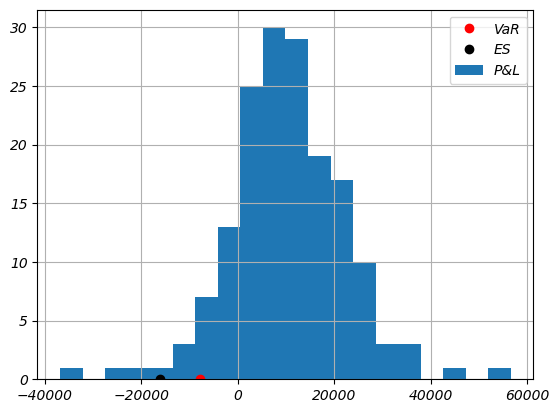

In [6]:
import numpy as np
import enum
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd


# This class defines puts and calls
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def IRSwap(CP, notional, K, t, Ti, Tm, n, P0T):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t
    ti_grid = np.linspace(Ti, Tm, int(n))
    tau = ti_grid[1] - ti_grid[0]

    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid < t)]
    if np.size(prevTi) > 0:  # prevTi != []:
        Ti = prevTi[-1]

    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid > t)]

    temp = 0.0

    for (idx, ti) in enumerate(ti_grid):
        if ti > Ti:
            temp = temp + tau * P0T(ti)

    P_t_Ti = P0T(Ti)
    P_t_Tm = P0T(Tm)

    if CP == OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * temp - (P_t_Ti - P_t_Tm)

    return swap * notional


def P0TModel(t, ti, ri, method):
    rInterp = method(ti, ri)
    r = rInterp(t)
    return np.exp(-r * t)


def YieldCurve(instruments, maturities, r0, method, tol):
    r0 = deepcopy(r0)
    ri = MultivariateNewtonRaphson(r0, maturities, instruments, method, tol=tol)
    return ri


def MultivariateNewtonRaphson(ri, ti, instruments, method, tol):
    err = 10e10
    idx = 0
    while err > tol:
        idx = idx + 1
        values = EvaluateInstruments(ti, ri, instruments, method)
        J = Jacobian(ti, ri, instruments, method)
        J_inv = np.linalg.inv(J)
        err = - np.dot(J_inv, values)
        ri[0:] = ri[0:] + err
        err = np.linalg.norm(err)
        # print('index in the loop is',idx,' Error is ', err)
    return ri


def Jacobian(ti, ri, instruments, method):
    eps = 1e-05
    swap_num = len(ti)
    J = np.zeros([swap_num, swap_num])
    val = EvaluateInstruments(ti, ri, instruments, method)
    ri_up = deepcopy(ri)

    for j in range(0, len(ri)):
        ri_up[j] = ri[j] + eps
        val_up = EvaluateInstruments(ti, ri_up, instruments, method)
        ri_up[j] = ri[j]
        dv = (val_up - val) / eps
        J[:, j] = dv[:]
    return J


def EvaluateInstruments(ti, ri, instruments, method):
    P0Ttemp = lambda t: P0TModel(t, ti, ri, method)
    val = np.zeros(len(instruments))
    for i in range(0, len(instruments)):
        val[i] = instruments[i](P0Ttemp)
    return val


def linear_interpolation(ti, ri):
    interpolator = lambda t: np.interp(t, ti, ri)
    return interpolator


def BuildYieldCurve(K, mat):
    # Convergence tolerance
    tol = 1.0e-15
    # Initial guess for the spine points
    r0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
    # Interpolation method
    method = linear_interpolation

    swap1 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[0], 0.0, 0.0, mat[0], 4 * mat[0], P0T)
    swap2 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[1], 0.0, 0.0, mat[1], 4 * mat[1], P0T)
    swap3 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[2], 0.0, 0.0, mat[2], 4 * mat[2], P0T)
    swap4 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[3], 0.0, 0.0, mat[3], 4 * mat[3], P0T)
    swap5 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[4], 0.0, 0.0, mat[4], 4 * mat[4], P0T)
    swap6 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[5], 0.0, 0.0, mat[5], 4 * mat[5], P0T)
    swap7 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[6], 0.0, 0.0, mat[6], 4 * mat[6], P0T)
    swap8 = lambda P0T: IRSwap(OptionTypeSwap.PAYER, 1, K[7], 0.0, 0.0, mat[7], 4 * mat[7], P0T)
    instruments = [swap1, swap2, swap3, swap4, swap5, swap6, swap7, swap8]

    # determine optimal spine points
    ri = YieldCurve(instruments, mat, r0, method, tol)
    # print('\n Spine points are',ri,'\n')

    # Build a ZCB-curve/yield curve from the spine points
    P0T = lambda t: P0TModel(t, mat, ri, method)
    return P0T, instruments


def Portfolio(P0T):
    # IRSwap(CP,           notional,          K,   t,   Ti,  Tm,   n,      P0T):
    value = IRSwap(OptionTypeSwap.RECEIVER, 1000000, 0.02, 0.0, 0.0, 20, 20, P0T) + \
            IRSwap(OptionTypeSwap.PAYER, 500000, 0.01, 0.0, 0.0, 10, 20, P0T) + \
            IRSwap(OptionTypeSwap.RECEIVER, 25000, 0.02, 0.0, 0.0, 30, 60, P0T) + \
            IRSwap(OptionTypeSwap.PAYER, 74000, 0.005, 0.0, 0.0, 5, 10, P0T) + \
            IRSwap(OptionTypeSwap.RECEIVER, 254000, 0.032, 0.0, 0.0, 15, 10, P0T) + \
            IRSwap(OptionTypeSwap.RECEIVER, 854000, 0.01, 0.0, 0.0, 7, 20, P0T) + \
            IRSwap(OptionTypeSwap.PAYER, 350000, 0.028, 0.0, 0.0, 10, 20, P0T) + \
            IRSwap(OptionTypeSwap.PAYER, 1000000, -0.01, 0.0, 0.0, 5, 20, P0T) + \
            IRSwap(OptionTypeSwap.RECEIVER, 1000000, 0.01, 0.0, 0.0, 14, 20, P0T) + \
            IRSwap(OptionTypeSwap.PAYER, 1000000, 0.03, 0.0, 0.0, 2, 4, P0T)

    return value

def mainCode():
    marketdataXLS=pd.read_excel('C:/Users/lenovo/project/machine learning project/Intrest rate andXva finenical egneering/Risk managment/MrktData.xlsx')
    #Divedie the qute by 100 for value

    marketData=np.array(marketdataXLS)/100.0
    shape=np.shape(marketData)
    NoOfScan=shape[0]
    NoOfInsts=shape[1]

    Scenarios=np.zeros([NoOfScan-1,NoOfInsts])
    for i in range(0,NoOfScan-1):
        for j in range(0, NoOfInsts):
            Scenarios[i, j] = marketData[i + 1, j] - marketData[i, j]

        # Construct instruments for TODAY's curve
    Swaps_mrkt = np.array([0.08, 0.2, 0.4, 0.77, 1.07, 1.29, 1.82, 1.9]) / 100
    mat = np.array([1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])
    # Given market quotes for swaps and scenarios we generate now "shocked" yield curves
    Swaps_markt_shocked=np.zeros([NoOfScan-1,NoOfInsts])
    for i in range(0,NoOfScan-1):
        for j in range(0, NoOfInsts):
            Swaps_markt_shocked[i,j]=Swaps_mrkt[j]+Scenarios[i,j]

    # For every shocked market scenario we build a yield curve
    YC_for_VaR=[]
    for i in range(0,NoOfScan-1):
        P0T, instruments = BuildYieldCurve(Swaps_markt_shocked[i,:], mat)
        YC_for_VaR.append(P0T)
        print('Scenario number',i,' out of  ', NoOfScan-1)

    # For every shocked yield curve we re-value the portfolio of interest rate derivatives
    PortfolioPV = np.zeros([NoOfScan-1])
    for i in range(0,NoOfScan-1):
        PortfolioPV[i] = Portfolio(YC_for_VaR[i])

    #current Yeild curve
    Yc_today,insts=BuildYieldCurve(Swaps_mrkt, mat)
    print('Current Portfolio PV is ', Portfolio(Yc_today))

    # Histograms and Var Calculatiosn
    plt.figure(1)
    plt.grid()
    plt.hist(PortfolioPV, 20)

    # VaR calculation
    alpha = 0.05
    HVaR_estimate = np.quantile(PortfolioPV, alpha)
    print('(H)VaR for alpha = ', alpha, ' is equal to=', HVaR_estimate)

    # Expected shortfal
    condLosses = PortfolioPV[PortfolioPV < HVaR_estimate]
    print('P&L which < VaR_alpha =', condLosses)
    ES = np.mean(condLosses)

    print('Expected shortfal = ', ES)

    plt.plot(HVaR_estimate, 0, 'or')
    plt.plot(ES, 0, 'ok')
    plt.legend(['VaR', 'ES', 'P&L'])
   



if __name__ == "__main__":
    mainCode()



